In [ ]:
import re

import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_predict,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from wordcloud import WordCloud

## Data

### LinkedIn Scrapped Data

In [26]:
def clean_text(text):
    # Remove anything between double quotes
    text = re.sub(r"\".*?\"", "", text)
    # Remove anything between brackets
    text = re.sub(r"\(.*?\)", "", text)
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002500-\U00002BEF"  # Chinese characters
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010FFFF"
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u200d"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"  # Dingbats
        "\u3030"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub(r"", text)
    # Remove non-alphanumeric characters except accents and apostrophes, and convert to lowercase
    text = re.sub(r"[^a-zA-ZÀ-ÖØ-öø-ÿ\' ]", "", text).lower()
    # Remove or normalize whitespaces (strip leading/trailing and replace multiple spaces with a single space)
    text = " ".join(text.split())
    # Keep only the first word
    text = text.split(" ")[0] if text else None
    return text

In [27]:
# Define function for cleaning LinkedIn data
def clean_linkedin_data(df):
    df = df.copy()
    # Remove duplicate entries based on the 'linkedin_profile_url' column
    df = df.drop_duplicates("linkedin_profile_url")
    # Select only the 'first_name' and 'is_french' columns and drop rows with missing values
    df = df[["first_name", "is_french"]].dropna()
    # Convert the 'first_name' column to a string data type
    df["first_name"] = df["first_name"].astype(str)
    # Convert the 'is_french' column to a boolean data type
    df["is_french"] = df["is_french"].astype("boolean")
    # Clean the 'first_name' column using the 'clean_text' function
    df["first_name"] = df["first_name"].apply(lambda name: clean_text(str(name)))
    return df


# Create a data transformation pipeline for cleaning LinkedIn data
linkedin_pipeline = Pipeline(
    [("clean_data", FunctionTransformer(func=clean_linkedin_data))]
)

# Load LinkedIn data from an Excel file
linkedin_df = pd.read_excel("./data/linkedin_scrapped_profiles.xlsx")

# Apply the transformation pipeline to clean the data
linkedin_cleaned = linkedin_pipeline.fit_transform(linkedin_df)
# Drop any remaining rows with missing values after transformation
linkedin_cleaned = linkedin_cleaned.dropna()
# Display the first few rows of the cleaned DataFrame
linkedin_cleaned.head()

,first_name,is_french
0,anne,False
1,annie,False
2,boyuan,False
3,brendan,False
4,bryce,False


In [28]:
# Display the shape of the cleaned DataFrame
linkedin_cleaned.shape

(16987, 2)

In [29]:
# Count the number of missing values (NaNs) in each column of the cleaned DataFrame
linkedin_cleaned.isnull().sum()

first_name    0
is_french     0
dtype: int64

### INSEE Data

In [30]:
# Define function for cleaning INSEE data
def clean_insee_data(df):
    # Drop rows with missing values and filter invalid data
    df = df.copy().dropna()
    df = df.query("annais != 'XXXX'").query("preusuel != '_PRENOMS_RARES'")
    df["annais"] = df["annais"].astype("int")
    df = df.query("annais >= 1960")
    # Clean the 'preusuel' column
    df.loc[:, "preusuel"] = df["preusuel"].apply(
        lambda name: str(name)
        .split("(")[0]
        .replace(
            r"[^a-zA-ZÀ-ÖØ-öø-ÿ\' ]",
            "",
        )
        .lower()
        # .split(" ")[0]
    )
    return df


# Define function to aggregate and repeat based on frequency
def aggregate_and_repeat(df):
    insee_count_df = (
        df.copy()
        .groupby("preusuel")["nombre"]
        .sum()
        .reset_index()
        .sort_values("nombre")
    )
    insee_count_df = insee_count_df.query("nombre > 10000", engine="python")
    insee_count_df.loc[:, "freq"] = insee_count_df["nombre"].apply(
        lambda x: int(x / 10000)
    )
    final_insee_df = insee_count_df.loc[
        insee_count_df.index.repeat(insee_count_df["freq"])
    ].reset_index(drop=True)[["preusuel"]]
    final_insee_df["is_french"] = True
    final_insee_df.columns = ["first_name", "is_french"]
    return final_insee_df


# Create pipeline for INSEE data
insee_pipeline = Pipeline(
    [
        ("clean_data", FunctionTransformer(func=clean_insee_data)),
        ("aggregate_repeat", FunctionTransformer(func=aggregate_and_repeat)),
    ]
)

# Load and transform INSEE data using the pipeline
insee_df = pd.read_csv("./data/dpt2022_csv/dpt2022.csv", sep=";")

insee_cleaned = insee_pipeline.fit_transform(insee_df)
insee_cleaned.head()

C:\Users\neha\AppData\Local\Temp\ipykernel_38068\1763273215.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insee_count_df.loc[:, "freq"] = insee_count_df["nombre"].apply(


,first_name,is_french
0,soline,True
1,amel,True
2,justin,True
3,imane,True
4,walid,True


In [31]:
insee_cleaned.shape

(3395, 2)

### Combine Data

In [32]:
# Concatenate LinkedIn and INSEE data
final_df = pd.concat([linkedin_cleaned, insee_cleaned], ignore_index=True)
final_df = final_df
final_df.head()

,first_name,is_french
0,anne,False
1,annie,False
2,boyuan,False
3,brendan,False
4,bryce,False


In [33]:
final_df.shape

(20382, 2)

In [ ]:
final_df.to_csv("data/final_first_name_dataset.csv", index=False)

## EDA

In [35]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20382 entries, 0 to 20381
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_name  20382 non-null  object 
 1   is_french   20382 non-null  boolean
dtypes: boolean(1), object(1)
memory usage: 199.2+ KB


In [36]:
final_df.describe()

,first_name,is_french
count,20382,20382
unique,6000,2
top,michael,False
freq,238,16508


In [37]:
final_df.isnull().sum()

first_name    0
is_french     0
dtype: int64

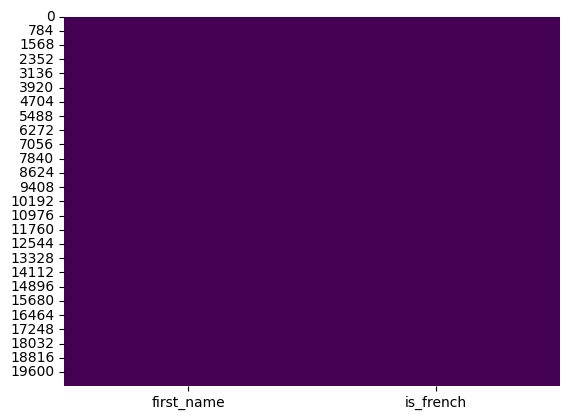

In [38]:
sns.heatmap(final_df.isnull(), cbar=False, cmap="viridis")
plt.show()

is_french
False    16508
True      3874
Name: count, dtype: Int64


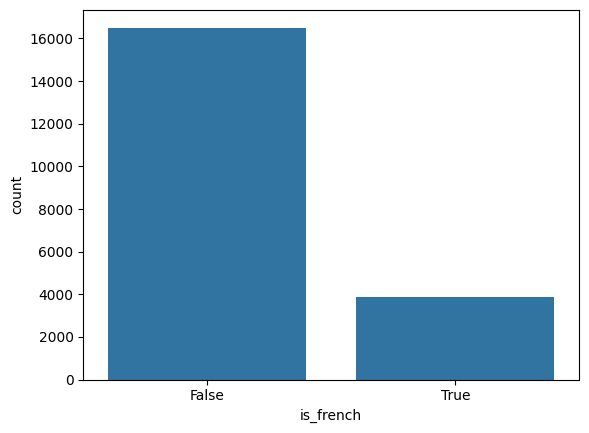

In [39]:
# Assuming 'target' is your column for classification
target_col = "is_french"  # Replace with the actual column name
print(final_df[target_col].value_counts())

# Plot target distribution
sns.countplot(x=target_col, data=final_df)
plt.show()

In [40]:
print(final_df["is_french"].value_counts(normalize=True))

is_french
False    0.80993
True     0.19007
Name: proportion, dtype: Float64


In [41]:
eda_df = final_df.copy()
eda_df = eda_df.drop_duplicates("first_name")

In [42]:
# Add a column for name length
eda_df["name_length"] = eda_df["first_name"].apply(len)

# Compare average name length for both classes
print(eda_df.groupby("is_french")["name_length"].mean())

is_french
False    5.749636
True     6.517578
Name: name_length, dtype: float64


In [43]:
# Add a column for the first letter
eda_df["first_letter"] = eda_df["first_name"].str[0].str.upper()

# Compare frequency of first letters between the classes
print(pd.crosstab(eda_df["first_letter"], eda_df["is_french"]))

is_french     False  True 
first_letter              
A               639     56
B               181     16
C               295     39
D               222     10
E               173     22
F               100     23
G               147     24
H               200     11
I                93      7
J               354     34
K               297     18
L               227     42
M               431     68
N               232     18
O                62      6
P               187     13
Q                23      1
R               292     18
S               607     32
T               227     16
U                29      0
V               122     11
W                55      4
X                29      4
Y               160     16
Z               102      3
Á                 1      0
Ø                 1      0


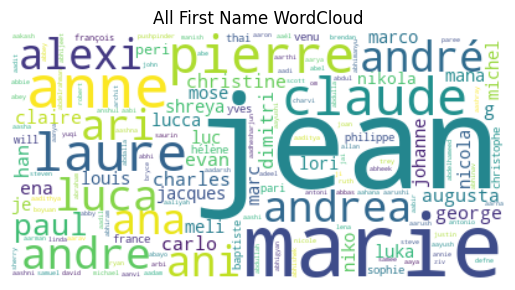

In [44]:
first_name_text = " ".join(
    final_df["first_name"].str.replace(" ", "_").str.lower().unique()
)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(first_name_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("All First Name WordCloud")
plt.axis("off")
plt.show()

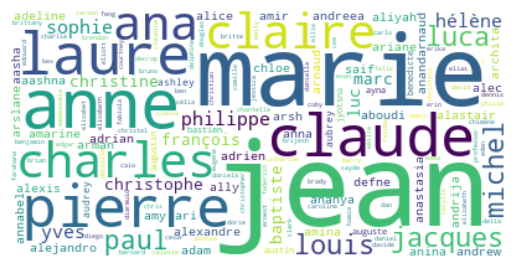

In [45]:
french_first_name_text = " ".join(
    final_df[final_df["is_french"] == True]["first_name"]
    .str.replace(" ", "_")
    .str.lower()
    .str.strip()
    .unique()
)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(french_first_name_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

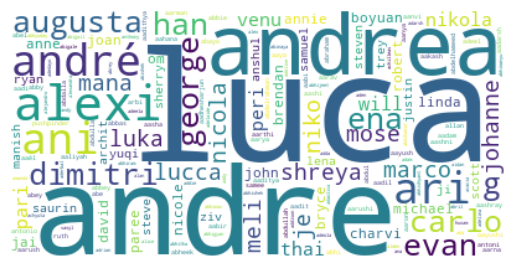

In [46]:
non_french_first_name_text = " ".join(
    final_df[final_df["is_french"] == False]["first_name"]
    .str.replace(" ", "_")
    .str.lower()
    .str.strip()
    .unique()
)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(non_french_first_name_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Model

```bash
mlflow server --host 127.0.0.1 --port 8080
```

In [47]:
MLFLOW_TRACKING_URI = "http://127.0.0.1:8080/"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [49]:
# Start MLFlow experiment
mlflow.set_experiment("final_first_name_is_french_binary_classification")

2024/11/11 21:40:59 INFO mlflow.tracking.fluent: Experiment with name 'final_first_name_is_french_binary_classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/898628863932426485', creation_time=1731357659703, experiment_id='898628863932426485', last_update_time=1731357659703, lifecycle_stage='active', name='final_first_name_is_french_binary_classification', tags={}>

In [50]:
# Function to save and log the dataset
def log_dataset(df, file_name="dataset.csv"):
    dataset_path = f"./data/{file_name}"
    df.to_csv(dataset_path, index=False)  # Save dataset as a CSV file
    mlflow.log_artifact(dataset_path)  # Log dataset as an artifact in MLFlow

In [51]:
# Define the model evaluation function
def evaluate_model(model, model_name, X_test, y_test, y_pred):
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC curve and AUC
    y_prob = model.predict_proba(X_test)[
        :, 1
    ]  # Get the predicted probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Log metrics to MLFlow
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
    }
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(model, model_name)

    # Return metrics and ROC data for potential plotting elsewhere
    return metrics

In [52]:
# Define the model evaluation function for cross_validation
def evaluate_model_cv(model, model_name, y, y_pred, y_prob=None):
    # Compute metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Calculate ROC curve and AUC if probabilities are provided
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
    else:
        roc_auc = None

    # Log metrics to MLFlow
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
    }
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(model, model_name)

    # Return metrics
    return metrics

In [ ]:
# Define the function to plot, display, save, and log the ROC curve
def plot_and_log_roc_curve(y_test, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Characteristic - {model_name}")
    plt.legend(loc="lower right")

    # Save the plot to a file
    plot_filename = f"./images/roc_curve_{model_name}.png"
    plt.savefig(plot_filename)  # Save the plot as an image file
    plt.show()  # Display the plot
    plt.close()  # Close the plot to free up memory

    # Log the plot to MLflow as an artifact
    mlflow.log_artifact(plot_filename)

    print(f"ROC curve saved and logged as {plot_filename}")

### Baseline Models

2024/11/11 21:41:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression Metrics:
{'Accuracy': 0.8807947019867549, 'Precision': 0.6391213389121339, 'Recall': 0.8125, 'F1 Score': 0.7154566744730679, 'ROC AUC': 0.9162254039353702}


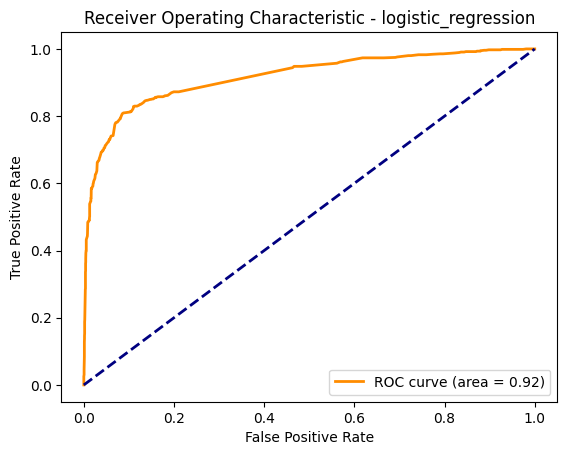

ROC curve saved and logged as roc_curve_logistic_regression.png


2024/11/11 21:42:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Metrics:
{'Accuracy': 0.8803041452048075, 'Precision': 0.6363636363636364, 'Recall': 0.8191489361702128, 'F1 Score': 0.7162790697674418, 'ROC AUC': 0.9166549352103665}


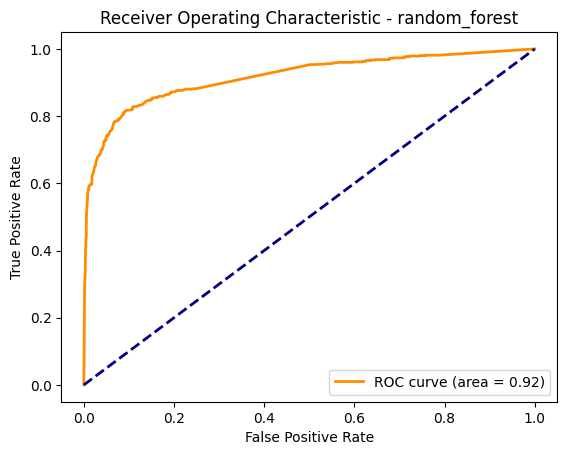

ROC curve saved and logged as roc_curve_random_forest.png


2024/11/11 21:42:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Naive Bayes Metrics:
{'Accuracy': 0.9143978415501595, 'Precision': 0.9352051835853131, 'Recall': 0.5757978723404256, 'F1 Score': 0.7127572016460906, 'ROC AUC': 0.8730195168772996}


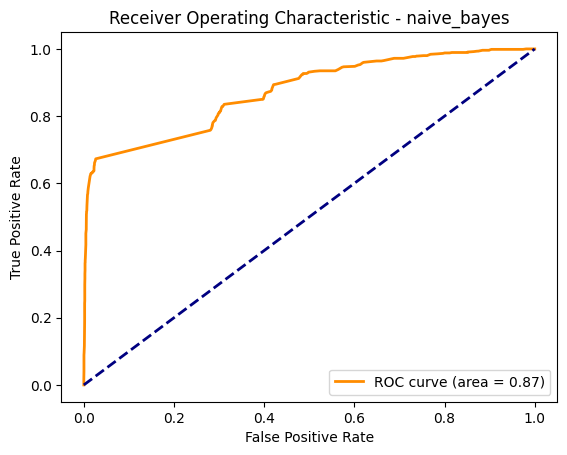

2024/11/11 21:42:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-fowl-306 at: http://127.0.0.1:8080/#/experiments/898628863932426485/runs/24e5bd65edbc4f64942b83c19043bfc1.
2024/11/11 21:42:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/898628863932426485.


ROC curve saved and logged as roc_curve_naive_bayes.png


In [54]:
# Start training and logging with MLFlow
with mlflow.start_run():

    # Log the dataset to MLFlow
    log_dataset(final_df, "final_first_name_dataset.csv")

    # Data Preparation
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(final_df["first_name"])  # Vectorize the first names
    y = final_df["is_french"]  # Target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Logistic Regression Model
    log_reg = LogisticRegression(
        class_weight="balanced",  # Handle class imbalance
        random_state=42,
    )
    log_reg.fit(X_train, y_train)  # Train the model
    log_reg_pred = log_reg.predict(X_test)  # Make predictions
    log_reg_prob = log_reg.predict_proba(X_test)[
        :, 1
    ]  # Get probabilities for the positive class

    # Log the Logistic Regression model and metrics
    log_reg_metrics = evaluate_model(
        log_reg, "logistic_regression", X_test, y_test, log_reg_pred
    )
    print(f"Logistic Regression Metrics:\n{log_reg_metrics}")
    plot_and_log_roc_curve(
        y_test, log_reg_prob, "logistic_regression"
    )  # Plot and log ROC curve

    # Random Forest
    rf_model = RandomForestClassifier(
        class_weight="balanced",  # Handle class imbalance
        random_state=42,
    )
    rf_model.fit(X_train, y_train)  # Train the model
    rf_pred = rf_model.predict(X_test)  # Make predictions
    rf_prob = rf_model.predict_proba(X_test)[
        :, 1
    ]  # Get probabilities for the positive class

    # Log the Random Forest model and metrics
    rf_metrics = evaluate_model(rf_model, "random_forest", X_test, y_test, rf_pred)
    print(f"Random Forest Metrics:\n{rf_metrics}")
    plot_and_log_roc_curve(y_test, rf_prob, "random_forest")  # Plot and log ROC curve

    # Naive Bayes
    nb_model = MultinomialNB()  # Instantiate the Naive Bayes classifier
    nb_model.fit(X_train, y_train)  # Train the model
    nb_pred = nb_model.predict(X_test)  # Make predictions
    nb_prob = nb_model.predict_proba(X_test)[
        :, 1
    ]  # Get probabilities for the positive class

    # Log the Naive Bayes model and metrics
    nb_metrics = evaluate_model(nb_model, "naive_bayes", X_test, y_test, nb_pred)
    print(f"Naive Bayes Metrics:\n{nb_metrics}")
    plot_and_log_roc_curve(y_test, nb_prob, "naive_bayes")  # Plot and log ROC curve

mlflow.end_run()

2024/11/11 22:13:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression (Cross-Validation) Metrics:
{'Accuracy': 0.8841134334216465, 'Precision': 0.6662269129287599, 'Recall': 0.7821373257614869, 'F1 Score': 0.7195440512942294, 'ROC AUC': 0.9009971026391173}


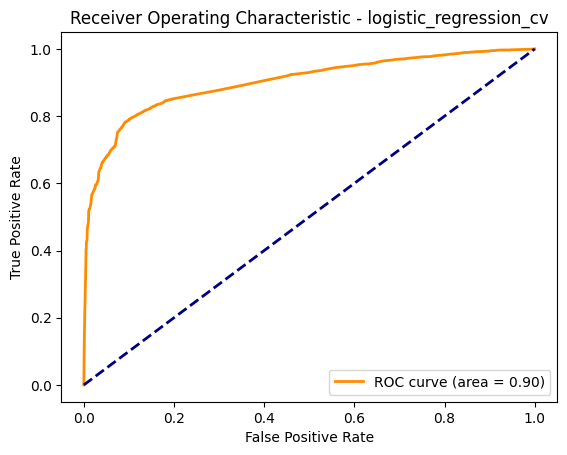

ROC curve saved and logged as roc_curve_logistic_regression_cv.png


2024/11/11 22:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest (Cross-Validation) Metrics:
{'Accuracy': 0.8808752821116672, 'Precision': 0.6562229904926534, 'Recall': 0.7839442436757873, 'F1 Score': 0.714420136438485, 'ROC AUC': 0.898123368854562}


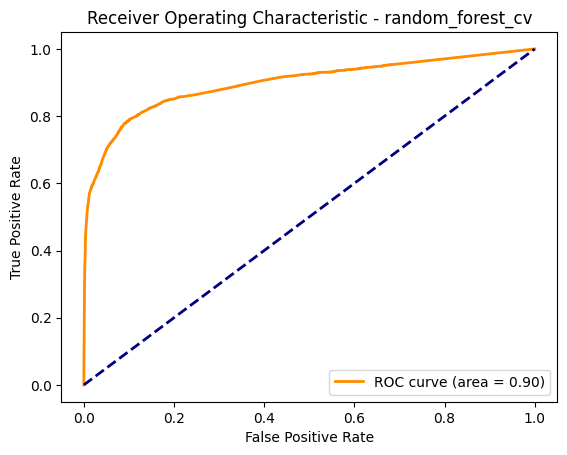

ROC curve saved and logged as roc_curve_random_forest_cv.png


2024/11/11 22:31:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Naive Bayes (Cross-Validation) Metrics:
{'Accuracy': 0.9067314296928662, 'Precision': 0.938249666814749, 'Recall': 0.5451729478575116, 'F1 Score': 0.6896326530612245, 'ROC AUC': 0.8529953218658146}


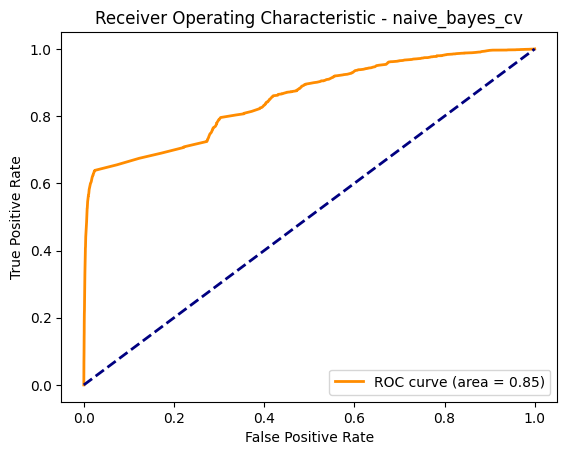

2024/11/11 22:31:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-kit-372 at: http://127.0.0.1:8080/#/experiments/898628863932426485/runs/81f586b2cd00471f822bd5d55fcb7148.
2024/11/11 22:31:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/898628863932426485.


ROC curve saved and logged as roc_curve_naive_bayes_cv.png


In [ ]:
# Start training and logging with MLFlow
with mlflow.start_run():

    # Log the dataset to MLFlow
    log_dataset(final_df, "final_first_name_dataset.csv")

    # Data Preparation
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(final_df["first_name"])  # Vectorize the first names
    y = final_df["is_french"]  # Target variable

    # Set up cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Logistic Regression with Cross-Validation
    log_reg = LogisticRegression(
        class_weight="balanced",  # Handle class imbalance
        random_state=42,
    )
    log_reg_pred = cross_val_predict(
        log_reg, X, y, cv=skf, method="predict"
    )  # Cross-validated predictions
    log_reg_prob = cross_val_predict(log_reg, X, y, cv=skf, method="predict_proba")[
        :, 1
    ]  # Cross-validated probabilities

    # Evaluate and log the Logistic Regression model
    log_reg_metrics_cv = evaluate_model_cv(
        log_reg, "logistic_regression_cv", y, log_reg_pred, y_prob=log_reg_prob
    )
    print(f"Logistic Regression (Cross-Validation) Metrics:\n{log_reg_metrics_cv}")
    plot_and_log_roc_curve(
        y, log_reg_prob, "logistic_regression_cv"
    )  # Plot and log ROC curve

    # Random Forest with Cross-Validation
    rf_model = RandomForestClassifier(
        class_weight="balanced",  # Handle class imbalance
        random_state=42,
    )
    rf_pred = cross_val_predict(
        rf_model, X, y, cv=skf, method="predict"
    )  # Cross-validated predictions
    rf_prob = cross_val_predict(rf_model, X, y, cv=skf, method="predict_proba")[
        :, 1
    ]  # Cross-validated probabilities

    # Evaluate and log the Random Forest model
    rf_metrics_cv = evaluate_model_cv(
        rf_model, "random_forest_cv", y, rf_pred, y_prob=rf_prob
    )
    print(f"Random Forest (Cross-Validation) Metrics:\n{rf_metrics_cv}")
    plot_and_log_roc_curve(y, rf_prob, "random_forest_cv")  # Plot and log ROC curve

    # Naive Bayes with Cross-Validation
    nb_model = MultinomialNB()  # Instantiate the Naive Bayes classifier
    nb_pred = cross_val_predict(
        nb_model, X, y, cv=skf, method="predict"
    )  # Cross-validated predictions
    nb_prob = cross_val_predict(nb_model, X, y, cv=skf, method="predict_proba")[
        :, 1
    ]  # Cross-validated probabilities

    # Evaluate and log the Naive Bayes model
    nb_metrics_cv = evaluate_model_cv(
        nb_model, "naive_bayes_cv", y, nb_pred, y_prob=nb_prob
    )
    print(f"Naive Bayes (Cross-Validation) Metrics:\n{nb_metrics_cv}")
    plot_and_log_roc_curve(y, nb_prob, "naive_bayes_cv")  # Plot and log ROC curve

mlflow.end_run()

---

## Model Tuning

2024/11/11 22:31:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression (Cross-Validation + Tuning) Metrics:
{'Accuracy': 0.8884800314002551, 'Precision': 0.7063676205207527, 'Recall': 0.7072792978833248, 'F1 Score': 0.706823165226364, 'ROC AUC': 0.8856603403377958}


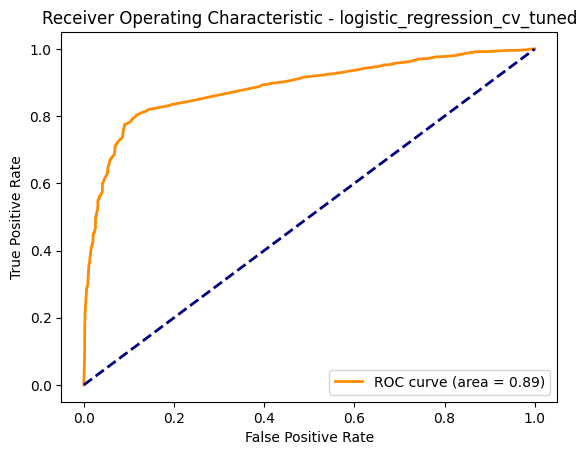

ROC curve saved and logged as roc_curve_logistic_regression_cv_tuned.png


2024/11/12 00:08:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest (Cross-Validation + Tuning) Metrics:
{'Accuracy': 0.8866647041507212, 'Precision': 0.8583868010999084, 'Recall': 0.4834796076406815, 'F1 Score': 0.618560105680317, 'ROC AUC': 0.8468612752515983}


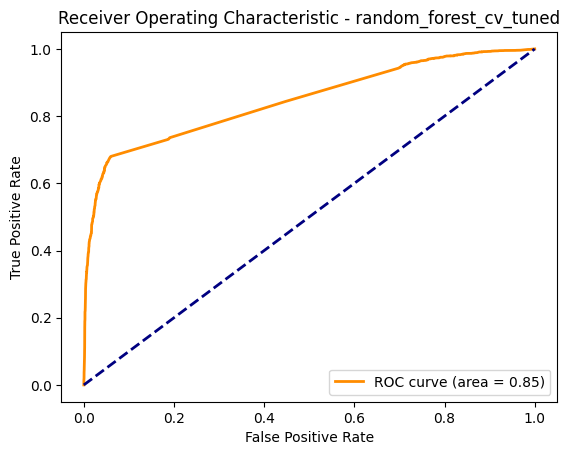

ROC curve saved and logged as roc_curve_random_forest_cv_tuned.png


2024/11/12 00:08:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Naive Bayes (Cross-Validation + Tuning) Metrics:
{'Accuracy': 0.9120302227455598, 'Precision': 0.8693645722399717, 'Recall': 0.6321631388745482, 'F1 Score': 0.7320280974443282, 'ROC AUC': 0.8660835928300716}


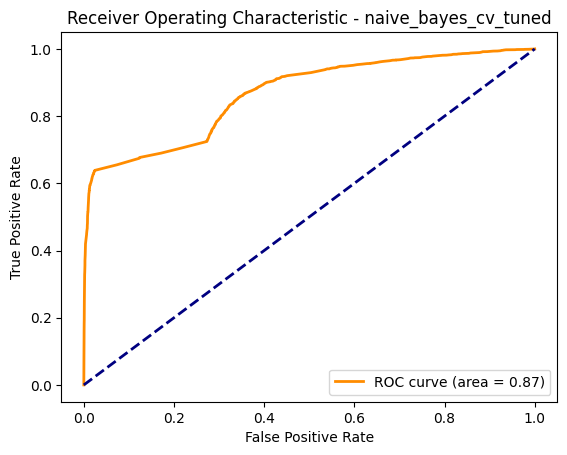

2024/11/12 00:08:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-pig-738 at: http://127.0.0.1:8080/#/experiments/898628863932426485/runs/b2e0d306ad7d41a8951a22831e98ab45.
2024/11/12 00:08:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/898628863932426485.


ROC curve saved and logged as roc_curve_naive_bayes_cv_tuned.png


In [58]:
# Start training and logging with MLFlow
with mlflow.start_run():

    # Log the dataset to MLFlow
    log_dataset(final_df, "final_first_name_dataset.csv")

    # Data Preparation
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(final_df["first_name"])  # Vectorize the first names
    y = final_df["is_french"]  # Target variable

    # Set up cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Logistic Regression with Grid Search
    log_reg = LogisticRegression(class_weight="balanced", random_state=42)
    log_reg_param_grid = {"C": [0.1, 1, 10], "solver": ["liblinear", "saga"]}
    log_reg_grid = GridSearchCV(log_reg, log_reg_param_grid, cv=skf, scoring="accuracy")
    log_reg_grid.fit(X, y)
    log_reg_best = log_reg_grid.best_estimator_  # Best model
    log_reg_pred = cross_val_predict(log_reg_best, X, y, cv=skf, method="predict")
    log_reg_prob = cross_val_predict(
        log_reg_best, X, y, cv=skf, method="predict_proba"
    )[:, 1]

    # Log and evaluate the Logistic Regression model
    log_reg_metrics_cv_tuned = evaluate_model_cv(
        log_reg_best,
        "logistic_regression_cv_tuned",
        y,
        log_reg_pred,
        y_prob=log_reg_prob,
    )
    print(
        f"Logistic Regression (Cross-Validation + Tuning) Metrics:\n{log_reg_metrics_cv_tuned}"
    )
    plot_and_log_roc_curve(
        y, log_reg_prob, "logistic_regression_cv_tuned"
    )  # Plot and log ROC curve

    # Random Forest with Grid Search
    rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
    rf_param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
    }
    rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=skf, scoring="accuracy")
    rf_grid.fit(X, y)
    rf_best = rf_grid.best_estimator_  # Best model
    rf_pred = cross_val_predict(rf_best, X, y, cv=skf, method="predict")
    rf_prob = cross_val_predict(rf_best, X, y, cv=skf, method="predict_proba")[:, 1]

    # Log and evaluate the Random Forest model
    rf_metrics_cv_tuned = evaluate_model_cv(
        rf_best, "random_forest_cv_tuned", y, rf_pred, y_prob=rf_prob
    )
    print(f"Random Forest (Cross-Validation + Tuning) Metrics:\n{rf_metrics_cv_tuned}")
    plot_and_log_roc_curve(
        y, rf_prob, "random_forest_cv_tuned"
    )  # Plot and log ROC curve

    # Naive Bayes (Grid Search typically less common, but demonstrating with alpha tuning)
    nb_model = MultinomialNB()
    nb_param_grid = {"alpha": [0.1, 1, 10]}
    nb_grid = GridSearchCV(nb_model, nb_param_grid, cv=skf, scoring="accuracy")
    nb_grid.fit(X, y)
    nb_best = nb_grid.best_estimator_  # Best model
    nb_pred = cross_val_predict(nb_best, X, y, cv=skf, method="predict")
    nb_prob = cross_val_predict(nb_best, X, y, cv=skf, method="predict_proba")[:, 1]

    # Log and evaluate the Naive Bayes model
    nb_metrics_cv_tuned = evaluate_model_cv(
        nb_best, "naive_bayes_cv_tuned", y, nb_pred, y_prob=nb_prob
    )
    print(f"Naive Bayes (Cross-Validation + Tuning) Metrics:\n{nb_metrics_cv_tuned}")
    plot_and_log_roc_curve(y, nb_prob, "naive_bayes_cv_tuned")  # Plot and log ROC curve

mlflow.end_run()